In [1]:
from read_dag import read_dag
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pydot
from matplotlib import cm

In [2]:
class Task:
    def __init__(self, id):
        self.id = id
        self.pid = None
        self.rank = None
        self.AFT = 0
        self.start = 0
        self.scheduled = False
        self.complete = False

class Processor:
    def __init__(self, id):
        self.id = id
        self.task_list = []
        self.time_avail = 0

    def add_task(self, task, min_EFT, pred_aft):
        self.task_list.append(task.id)
        task.AFT = min_EFT
        task.pid = self.id
        task.start = pred_aft
        self.time_avail = min_EFT
        print(f"Scheduling task {task.id} on processor {self.id} from {task.start} to {task.AFT}")
        return

class AEFT:
    def __init__(self, input_list=None, file=None, verbose=False, p=3, b=0.5, ccr=0.5):
        if input_list is None and file is not None:
            self.num_tasks, self.num_processors, self.comp_cost, self.graph = read_dag(file, p, b, ccr)
        elif len(input_list) == 4 and file is None:
            self.num_tasks, self.num_processors, self.comp_cost, self.graph = input_list
        else:
            print('Enter filename or input params')
            raise Exception()

        self.dependency_mx = np.logical_not(self.graph > -1)
        self.ioct_mx = self.calculate_IOCT()
        self.tasks = {i:Task(i) for i in range(self.num_tasks)}
        self.task_schedule = [self.tasks[0]]
        self.tasks[0].scheduled = True
        self.processors = {i:Processor(i) for i in range(self.num_processors)}
        self.calculate_rank()
        self.makespan = self.run_schedule()

    # Tasks are organized along the rows, processors are organized along the columns
    def calculate_IOCT(self):
        ioct_mx = np.copy(self.comp_cost)
        last_node = self.num_tasks - 1
        indices = np.where(self.graph != -1)  # indices[0] is row index of entries != -1, indices[1] is col index of entries != -1
    
        for node_index in range(last_node - 1, -1, -1):
            mask = indices[0] == node_index
            masked_idxs = (indices[0][mask], indices[1][mask])
            succ_ioct = ioct_mx[masked_idxs[1]]  # successor computational costs
    
            if succ_ioct.size == 0:
                continue
    
            min_arrs = []
            for proc in range(self.num_processors):
                comm_cost = self.graph[masked_idxs][:, np.newaxis].repeat(self.num_processors, axis=1)
                comm_cost[:, proc] = 0
                temp_ioct = comm_cost + succ_ioct
                min_ioct = np.min(temp_ioct, axis=1) # minimize along the processor axis
                min_arrs.append(min_ioct)
    
            min_arrs = np.column_stack(min_arrs)
            max_arr = np.max(min_arrs, axis=0) # maximize over the successor axis
            ioct_mx[node_index] += max_arr
    
        return ioct_mx
    
    def calculate_rank(self):
        rank_mx = np.mean(self.ioct_mx, axis=1)
        rank_dict = {}
        for idx, rank in enumerate(rank_mx):
            self.tasks[idx].rank = rank
        return

    def run_schedule(self):
        while len(self.task_schedule) > 0:
            task = self.get_highest_rank_task()
            # Get predecessors
            indices = np.where(self.graph != -1)
            mask = indices[1] == task.id
            masked_idxs = (indices[0][mask], indices[1][mask])
            EFT_dict = {}
            IEFT_dict = {}
            EST_dict = {}
            for pid, proc in self.processors.items():
                # Check for start node
                if len(masked_idxs[0]) == 0:
                        max_aft = 0
                else:
                    # Calculate AFT for predecessor tasks
                    aft_arr = np.zeros(len(masked_idxs[0]))
                    comm_cost = self.graph[masked_idxs]
                    pred_tasks = [self.tasks[idx] for idx in masked_idxs[0]]
                    for i, pred_task in enumerate(pred_tasks):
                        # Include communication cost if we need to transfer data
                        if pred_task.pid != pid:
                            aft_arr[i] += pred_task.AFT + comm_cost[i]
                        else:
                            aft_arr[i] += pred_task.AFT
                    max_aft = np.max(aft_arr)
                
                EST = max([proc.time_avail, max_aft])
                EFT = EST + self.comp_cost[task.id, pid]
                IEFT = EFT + self.ioct_mx[task.id, pid]
                EST_dict[pid] = EST
                EFT_dict[pid] = EFT
                IEFT_dict[pid] = IEFT
            outd = np.count_nonzero(self.graph[task.id] > -1)
            
            if outd > self.num_processors:
                min_EFT = float('inf')
                best_pid = None
                for pid, EFT in EFT_dict.items():
                    if EFT < min_EFT:
                        best_pid = pid
                        min_EFT = EFT
                if best_pid is not None:
                    self.processors[best_pid].add_task(task, EFT_dict[best_pid], EST_dict[best_pid])
            else:
                min_IEFT = float('inf')
                best_pid = None
                for pid, IEFT in IEFT_dict.items():
                    if IEFT < min_IEFT:
                        best_pid = pid
                        min_IEFT = IEFT
                if best_pid is not None:
                    self.processors[best_pid].add_task(task, EFT_dict[best_pid], EST_dict[best_pid])                
            # Update the schedule
            self.update_task_schedule(task.id)
        print(f"Completed Schedule! Makespan={task.AFT}")
        return task.AFT  # This is the makespan

    # Mark task as complete, update dependencies, and schedule new tasks (if they are not already scheduled)
    def update_task_schedule(self, task_id):
        self.tasks[task_id].complete = True
        self.dependency_mx[task_id,:] = True # set all values in the row to true, signaling the dependency is complete
        check_ready = np.all(self.dependency_mx,axis=0)
        ready_idxs = np.where(check_ready==True)[0]
        for idx in ready_idxs:
            task = self.tasks[idx]
            if not task.scheduled:
                task.scheduled = True
                self.task_schedule.append(task)
        return

    # Return the highest ranking task in the schedule
    # Remove the task from the schedule
    def get_highest_rank_task(self):
        rank = -1
        highest_rank_task = None
        for task in self.task_schedule:
            if task.rank > rank:
                highest_rank_task = task
                rank = task.rank
        if highest_rank_task is not None:
            self.task_schedule.remove(highest_rank_task)
        else:
            raise ValueError("No task with a valid rank found in the task schedule.")
        return highest_rank_task
    
    def show_graph(self, show_edge_weights=False):     
        G = nx.from_numpy_array(self.graph + 1, create_using=nx.DiGraph) # graph is corrected so that non-edges are 0
        
        # Plot the graph
        plt.figure(figsize=(8, 6))
        pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
        nx.draw(G, pos, with_labels=True, node_color='white', edgecolors='black', node_size=2000, font_size=10, font_weight='bold', arrows=True)
        if show_edge_weights:
            edge_labels = nx.get_edge_attributes(G, 'weight')
            # subtract 1 from edge labels because we added 1 earlier for proper connections
            for key in edge_labels:
                edge_labels[key] -= 1
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        
        plt.title("DAG Visualization")
        plt.show()

    def show_schedule(self):
        fig, ax = plt.subplots(figsize=(12, 8))
    
        # Generate a color map for tasks (this ensures each task gets a unique color)
        cmap = plt.get_cmap('tab10')
        color_map = {task.id: cmap(i % 10) for i, task in enumerate(self.tasks.values())}
    
        # Plot tasks for each processor
        for pid, proc in self.processors.items():
            for task_id in proc.task_list:
                task = self.tasks[task_id]
                start_time = task.start  # Start time of the task
                duration = task.AFT - task.start  # Duration of the task
     
                # Plot the task as a horizontal bar on the processor line
                ax.barh(pid, duration, left=start_time, height=0.8, color=color_map[task.id],
                        label=f"Task {task.id}" if task.id not in ax.get_legend_handles_labels()[1] else "")
                # Calculate the position to place the label (centered inside the bar)
                label_position = start_time + duration / 2
                
                # Place the label inside the bar
                ax.text(label_position, pid, str(task.id), ha='center', va='center', color='white', fontsize=10)

        # Set axis labels
        ax.set_xlabel('Time')
        ax.set_ylabel('Processors')
        ax.set_title('Processor Task Scheduling')
    
        # Set the y-axis to show processor IDs
        ax.set_yticks([pid for pid in self.processors.keys()])
        ax.set_yticklabels([f'Processor {pid}' for pid in self.processors.keys()])
        
        # Add a legend for tasks, ensuring each task is only labeled once
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Tasks")
    
        # Tight layout to ensure the plot fits without clipping
        plt.tight_layout()
        plt.show()

    def __str__(self):
        return (
            f"AEFT Class Object:\n"
            f"- Number of tasks: {self.num_tasks}\n"
            f"- Number of processors: {self.num_processors}\n"
            f"- Makespan:{self.makespan}\n"
            f"- Computational cost:\n{self.comp_cost}\n"
            f"- IOCT:\n{self.ioct_mx}\n"
            f"- Rank IOCT:\n{[(self.tasks[t].id, self.tasks[t].rank) for t in range(self.num_tasks)]}\n"
            f"- Task dependency graph:\n{self.graph}"
        )

In [3]:
filename = 'dag/10_0.8_0.8_0.8_4.dot'
inputs = read_dag(filename, p=3, b=0.5, ccr=0.5)
aeft = AEFT(input_list=inputs)
print(aeft)

Scheduling task 0 on processor 0 from 0 to 0.0
Scheduling task 4 on processor 0 from 0.0 to 36.0
Scheduling task 3 on processor 2 from 0 to 33.0
Scheduling task 1 on processor 1 from 0 to 21.0
Scheduling task 5 on processor 1 from 21.0 to 45.0
Scheduling task 7 on processor 1 from 47.0 to 80.0
Scheduling task 8 on processor 2 from 53.0 to 83.0
Scheduling task 10 on processor 0 from 50.0 to 89.0
Scheduling task 9 on processor 1 from 80.0 to 112.0
Scheduling task 2 on processor 2 from 83.0 to 114.0
Scheduling task 6 on processor 0 from 89.0 to 117.0
Scheduling task 11 on processor 0 from 117.0 to 117.0
Completed Schedule! Makespan=117.0
AEFT Class Object:
- Number of tasks: 12
- Number of processors: 3
- Makespan:117.0
- Computational cost:
[[ 0.  0.  0.]
 [19. 21. 22.]
 [30. 32. 31.]
 [47. 45. 33.]
 [36. 58. 50.]
 [20. 24. 25.]
 [28. 25. 34.]
 [36. 33. 43.]
 [39. 43. 30.]
 [37. 32. 34.]
 [39. 34. 32.]
 [ 0.  0.  0.]]
- IOCT:
[[76. 76. 76.]
 [58. 64. 65.]
 [30. 32. 31.]
 [86. 88. 76.]
 [

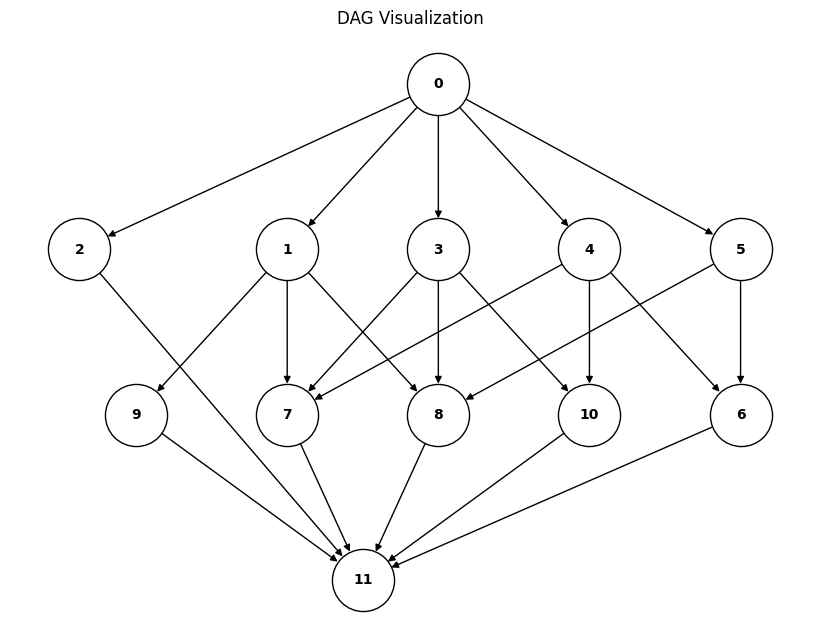

In [4]:
aeft.show_graph()

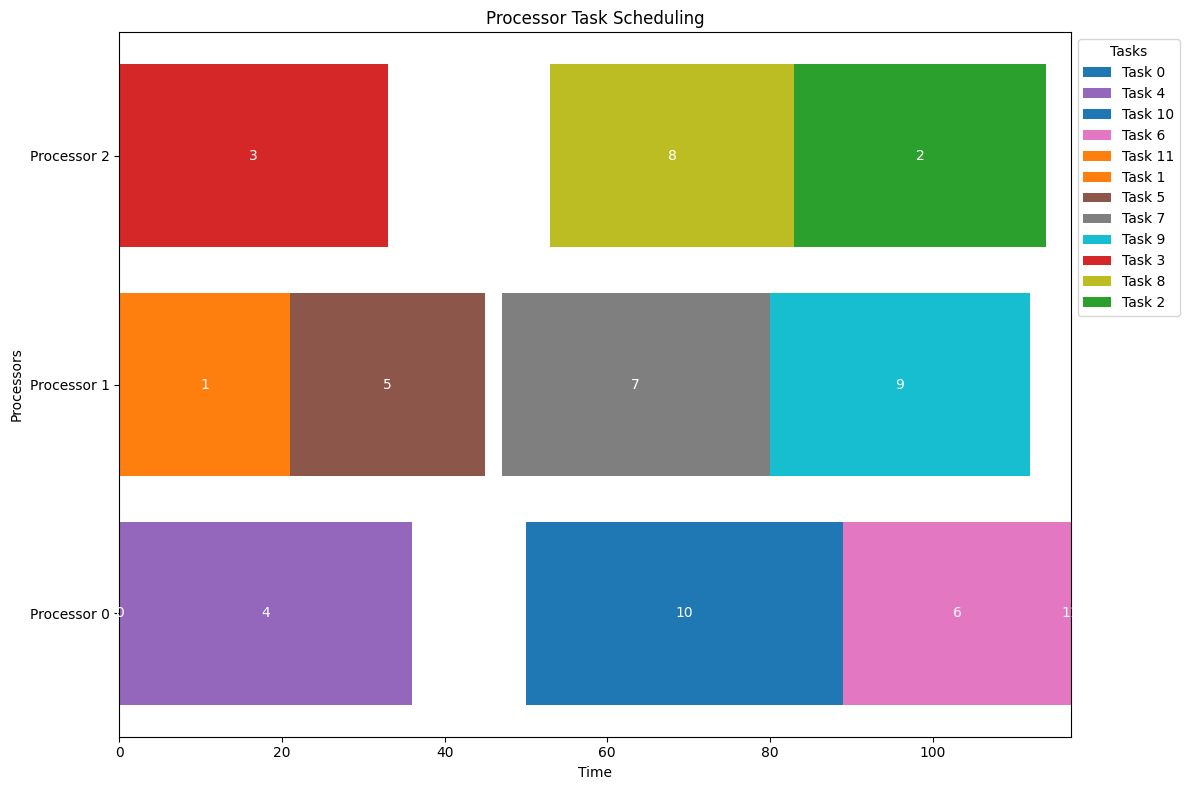

In [5]:
aeft.show_schedule()

In [6]:
# Number of tasks
num_tasks = 10

# Initialize the adjacency matrix with zeros
adj_matrix = np.zeros((num_tasks, num_tasks), dtype=int) -1

adj_matrix[0,1]=18
adj_matrix[0,2]=12
adj_matrix[0,3]=9
adj_matrix[0,4]=11
adj_matrix[0,5]=14
adj_matrix[1,7]=19
adj_matrix[1,8]=16
adj_matrix[2,6]=23
adj_matrix[3,7]=27
adj_matrix[3,8]=23
adj_matrix[4,8]=13
adj_matrix[5,7]=15
adj_matrix[6,9]=17
adj_matrix[7,9]=11
adj_matrix[8,9]=13


print(adj_matrix)
comp_cost_matrix = np.array([
    [14, 16,  9],  # T1
    [13, 19, 18],  # T2
    [11, 13, 19],  # T3
    [13,  8, 17],  # T4
    [12, 13, 10],  # T5
    [13, 16,  9],  # T6
    [ 7, 15, 11],  # T7
    [ 5, 11, 14],  # T8
    [18, 12, 20],  # T9
    [21,  7, 16]   # T10
])

print(comp_cost_matrix)

[[-1 18 12  9 11 14 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 19 16 -1]
 [-1 -1 -1 -1 -1 -1 23 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 27 23 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 13 -1]
 [-1 -1 -1 -1 -1 -1 -1 15 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 17]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 11]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 13]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[[14 16  9]
 [13 19 18]
 [11 13 19]
 [13  8 17]
 [12 13 10]
 [13 16  9]
 [ 7 15 11]
 [ 5 11 14]
 [18 12 20]
 [21  7 16]]


In [7]:
inputs = (10,3,comp_cost_matrix, adj_matrix)
aeft = AEFT(input_list=inputs)
print(aeft)

Scheduling task 0 on processor 2 from 0 to 9
Scheduling task 1 on processor 2 from 9 to 27
Scheduling task 3 on processor 1 from 18.0 to 26.0
Scheduling task 2 on processor 0 from 21.0 to 32.0
Scheduling task 4 on processor 1 from 26.0 to 39.0
Scheduling task 5 on processor 2 from 27 to 36
Scheduling task 8 on processor 1 from 43.0 to 55.0
Scheduling task 6 on processor 0 from 32.0 to 39.0
Scheduling task 7 on processor 0 from 53.0 to 58.0
Scheduling task 9 on processor 1 from 69.0 to 76.0
Completed Schedule! Makespan=76.0
AEFT Class Object:
- Number of tasks: 10
- Number of processors: 3
- Makespan:76.0
- Computational cost:
[[14 16  9]
 [13 19 18]
 [11 13 19]
 [13  8 17]
 [12 13 10]
 [13 16  9]
 [ 7 15 11]
 [ 5 11 14]
 [18 12 20]
 [21  7 16]]
- IOCT:
[[62 54 62]
 [48 38 53]
 [39 35 46]
 [51 27 53]
 [44 32 42]
 [36 34 39]
 [28 22 27]
 [23 18 30]
 [38 19 36]
 [21  7 16]]
- Rank IOCT:
[(0, 59.333333333333336), (1, 46.333333333333336), (2, 40.0), (3, 43.666666666666664), (4, 39.333333333

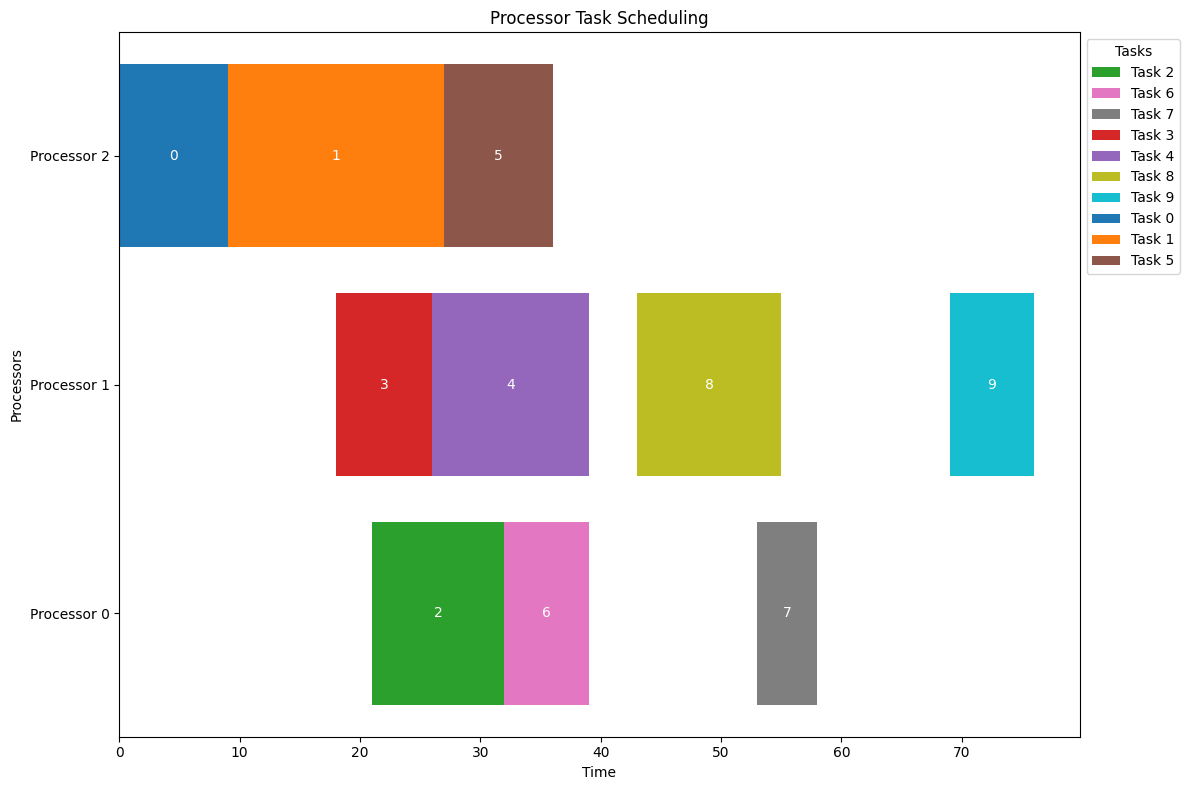

In [8]:
aeft.show_schedule()